In [1]:
%matplotlib inline

import sys
sys.path.insert(0,'../src')

import numpy as np
from matplotlib import pyplot as plt
import SimpleITK as sitk

from imagedisplay import myshow

<b>Otsu’s thresholding method</b> tries to minimize the weighted intra-class variance:
\begin{equation*}
\Sigma^2(t) = p( I(x) \leq t ) \cdot \sigma^2( I(x) \leq t ) + p( I(x) \gt t ) \cdot \sigma^2( I(x) \gt t )
\end{equation*}
The optimal threshold can be found via exhaustive search by computing $\Sigma^2(t)$ for all $t \in [0,255]$ and choosing the best one.

In [2]:
# Load input image
InputFilename = "../data/noisy.png"
image = sitk.ReadImage(InputFilename)

# Rescale image in range [0,255]
image = sitk.Cast(sitk.RescaleIntensity(image), sitk.sitkUInt8)

# Read maximum and minimum intensity values
stats = sitk.StatisticsImageFilter()
stats.Execute( image )
max = stats.GetMaximum()
min = stats.GetMinimum()
print 'Min intensity = {0} \nMax intensity = {1}'.format(min, max)

# Compute normalized image histogram
nbins = 256
img_data = sitk.GetArrayFromImage(image)
hist_norm,bins = np.histogram(img_data.flatten(),nbins,normed=True)
bins = np.arange(nbins)

# Compute cumulative distribution function
Q = hist_norm.cumsum()    

# Compute Otsu threshold value
fn_min = np.inf
thresh = -1
d = 1e-10

for i in xrange(0,256):
    p1,p2 = np.hsplit(hist_norm,[i]) # probabilities
    q1,q2 = Q[i],Q[255]-Q[i] # cum sum of classes
    b1,b2 = np.hsplit(bins,[i]) # weights

    # finding means and variances
    m1,m2 = np.sum(p1*b1)/(q1+d), np.sum(p2*b2)/(q2+d)
    v1,v2 = np.sum(((b1-m1)**2)*p1)/(q1+d),np.sum(((b2-m2)**2)*p2)/(q2+d)

    # calculates the minimization function
    fn = v1*q1 + v2*q2
    if fn < fn_min:
        fn_min = fn
        thresh = i

print 'Otsu threshold value = %d\n' % thresh

Min intensity = 0.0 
Max intensity = 255.0
Otsu threshold value = 106



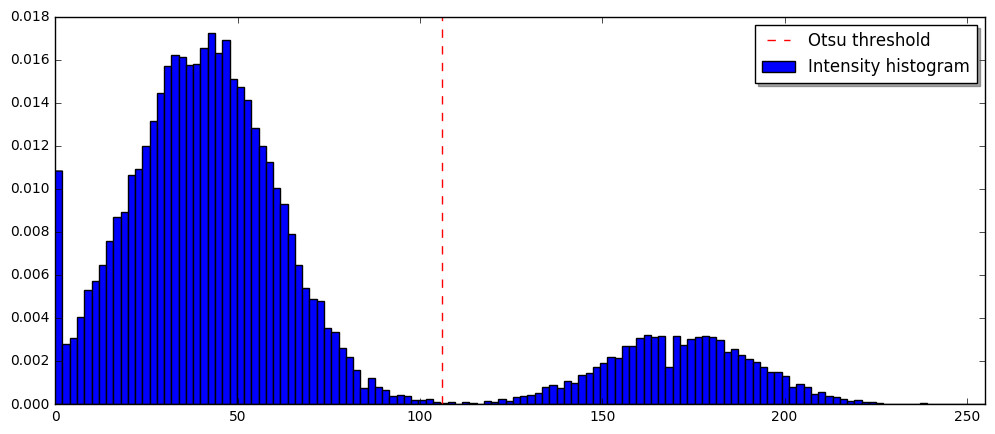

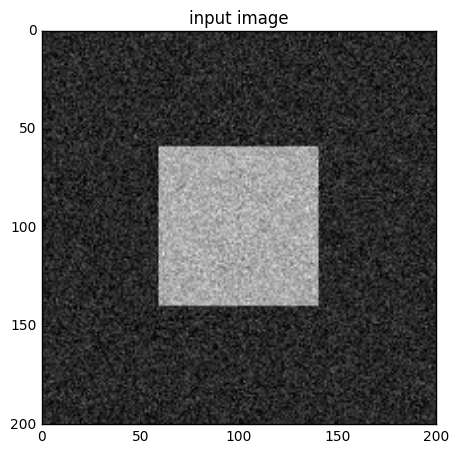

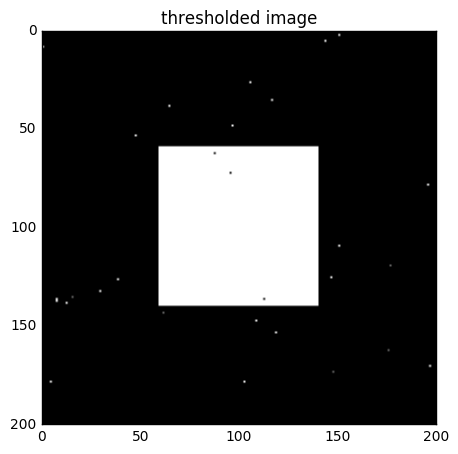

In [3]:
# Plot the intensity histogram
plt.figure(figsize=(12, 5), dpi=100)
plt.hist(img_data.flatten(), bins=128, range=(0, 255), normed=True, label='Intensity histogram')
plt.axvline(x=thresh, ymin=0, ymax=1, hold=None, linestyle='--', color='r', label='Otsu threshold')
plt.legend(loc=1, shadow=True)
x1,x2,y1,y2 = plt.axis(); plt.axis((0,255,y1,y2))
plt.show()        
        
# Compute the thresholded image 
image_thr=sitk.Threshold(image,0,thresh,255)
image_thr=sitk.Threshold(image_thr,thresh,255,0)

# Display the result
myshow(image,title='input image',dpi=48)
myshow(image_thr,title='thresholded image',dpi=48)